In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook

tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np

from packages.hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_exhaustive,
    pairs_from_covisibility,
)
from packages.hloc.visualization import plot_images, read_image
from packages.hloc.utils import viz_3d



In [2]:
from PIL import Image
import random

# Open an image
image = Image.open('/home/jkgao/Documents/GitHub/mirg/data/public_inspection_reports/data/images/start.png')

def zoom_image(image, zoom_factor=1.2, pattern_index=0, total_patterns=10):
    # Get the original size
    original_width, original_height = image.size

    # Calculate the size of the zoomed area
    crop_width = int(original_width / zoom_factor)
    crop_height = int(original_height / zoom_factor)

    # Calculate the grid size (total_patterns should define the grid)
    rows = cols = int(total_patterns**0.5)

    # Determine the position of the crop based on the pattern index
    row = pattern_index // cols
    col = pattern_index % cols

    # Calculate the left, top, right, bottom coordinates based on grid position
    left = int(col * (original_width - crop_width) / max(1, cols - 1))
    top = int(row * (original_height - crop_height) / max(1, rows - 1))
    right = left + crop_width
    bottom = top + crop_height

    # Crop the image to the specific area
    cropped_image = image.crop((left, top, right, bottom))

    # Resize the cropped image back to the original size
    zoomed_image = cropped_image.resize((original_width, original_height), Image.LANCZOS)
    return zoomed_image

# Apply patterned zoom to the image multiple times
total_patterns = 5  # Define the number of patterns
for i in range(total_patterns):
    zoom_factor = random.uniform(1.2, 2)
    zoomed_image = zoom_image(image, pattern_index=i, total_patterns=total_patterns)
    # Save the zoomed image
    zoomed_image.save(f"/home/jkgao/Documents/GitHub/mirg/data/public_inspection_reports/data/images/other_{i}.png")

# Setup
Here we define some output paths.

In [3]:
images = Path("/home/jkgao/Documents/GitHub/mirg/data/public_inspection_reports/data/images")
outputs = Path("outputs/demo/")
! rm -rf $outputs
sfm_pairs = outputs / "pairs-sfm.txt"
loc_pairs = outputs / "pairs-loc.txt"
sfm_dir = outputs / "sfm"
features = outputs / "features.h5"
matches = outputs / "matches.h5"

feature_conf = extract_features.confs["disk"]
matcher_conf = match_features.confs["disk+lightglue"]

references = [p.relative_to(images).as_posix() for p in (images).iterdir()]

In [4]:
extract_features.main(
    feature_conf, images, image_list=references, feature_path=features
)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

[2024/09/26 11:13:03 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


/home/jkgao/miniconda3/envs/hloc/lib/python3.9/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


  0%|          | 0/6 [00:00<?, ?it/s]

[2024/09/26 11:13:04 hloc INFO] Finished exporting features.
[2024/09/26 11:13:04 hloc INFO] Found 15 pairs.
[2024/09/26 11:13:04 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
/home/jkgao/miniconda3/envs/hloc/lib/python3.9/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


  0%|          | 0/15 [00:00<?, ?it/s]

[2024/09/26 11:13:04 hloc INFO] Finished exporting matches.


PosixPath('outputs/demo/matches.h5')

The we run incremental Structure-From-Motion and display the reconstructed 3D model.

In [5]:
model = reconstruction.main(
    sfm_dir, images, sfm_pairs, features, matches, image_list=references
)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(
    fig, model, color="rgba(255,0,0,0.5)", name="mapping", points_rgb=True
)
fig.show()

[2024/09/26 11:13:06 hloc INFO] Creating an empty database...


[2024/09/26 11:13:06 hloc INFO] Importing images into the database...
[2024/09/26 11:13:06 hloc INFO] Importing features into the database...


  0%|          | 0/6 [00:00<?, ?it/s]

[2024/09/26 11:13:06 hloc INFO] Importing matches into the database...


  0%|          | 0/15 [00:00<?, ?it/s]

[2024/09/26 11:13:06 hloc INFO] Performing geometric verification of the matches...
I20240926 11:13:06.400092 140417530009152 misc.cc:198] 
Feature matching
I20240926 11:13:06.400559 140417538401856 sift.cc:1457] Creating SIFT CPU feature matcher
I20240926 11:13:06.400560 140419149063744 sift.cc:1457] Creating SIFT CPU feature matcher
I20240926 11:13:06.400604 140414224954944 sift.cc:1457] Creating SIFT CPU feature matcher
I20240926 11:13:06.400609 140417546794560 sift.cc:1457] Creating SIFT CPU feature matcher
I20240926 11:13:06.400772 140414208169536 sift.cc:1457] Creating SIFT CPU feature matcher
I20240926 11:13:06.400775 140414216562240 sift.cc:1457] Creating SIFT CPU feature matcher
I20240926 11:13:06.400834 140414199776832 sift.cc:1457] Creating SIFT CPU feature matcher
I20240926 11:13:06.400979 140414174598720 sift.cc:1457] Creating SIFT CPU feature matcher
I20240926 11:13:06.401032 140414182991424 sift.cc:1457] Creating SIFT CPU feature matcher
I20240926 11:13:06.401049 1404141

We also visualize which keypoints were triangulated into the 3D model.

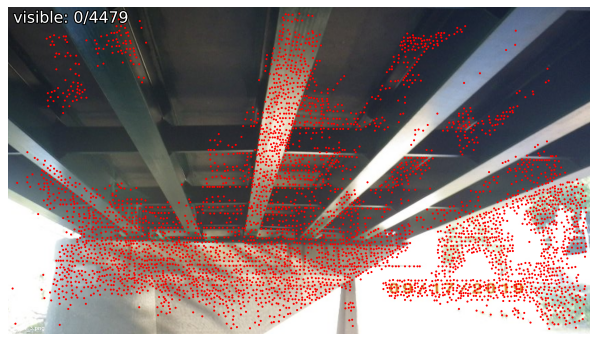

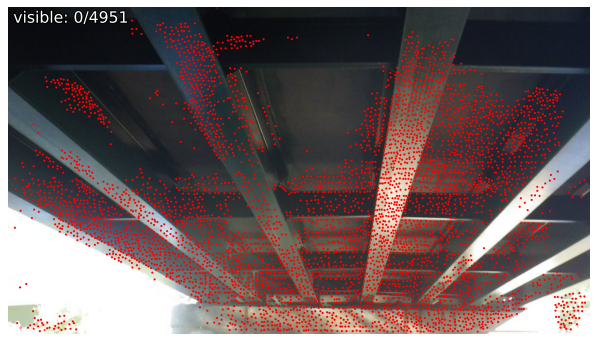

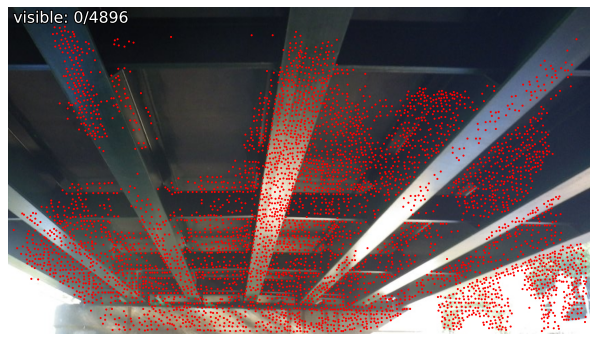

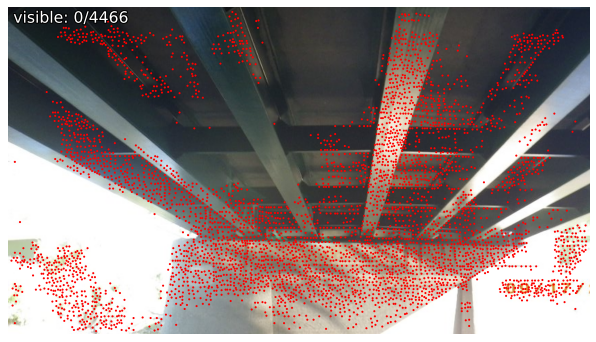

In [6]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=5)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

In [7]:
import os
image_dir = "/home/jkgao/Documents/GitHub/mirg/data/public_inspection_reports/data/200030002008022/viewreport.ashx-5/images"
for name in os.listdir(image_dir)[:5]:
    try:
        if not name.endswith('.png'):
            continue
        query = os.path.join(image_dir, name)
        extract_features.main(
            feature_conf, images, image_list=[query], feature_path=features, overwrite=True
        )
        pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
        match_features.main(
            matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True
        )
        import pycolmap
        from packages.hloc.localize_sfm import QueryLocalizer, pose_from_cluster

        camera = pycolmap.infer_camera_from_image(images / query)
        ref_ids = [model.find_image_with_name(r).image_id for r in references]
        conf = {
            "estimation": {"ransac": {"max_error": 12}},
            "refinement": {"refine_focal_length": True, "refine_extra_params": True},
        }
        localizer = QueryLocalizer(model, conf)
        ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)
        if ret:
            print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
        visualization.visualize_loc_from_log(images, query, log, model)
    except:
        continue

[2024/09/26 11:14:16 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/09/26 11:14:16 hloc INFO] Finished exporting features.
[2024/09/26 11:14:16 hloc INFO] Found 6 pairs.
[2024/09/26 11:14:16 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/6 [00:00<?, ?it/s]

[2024/09/26 11:14:17 hloc INFO] Finished exporting matches.
[2024/09/26 11:14:17 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/09/26 11:14:17 hloc INFO] Finished exporting features.
[2024/09/26 11:14:17 hloc INFO] Found 6 pairs.
[2024/09/26 11:14:17 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/6 [00:00<?, ?it/s]

[2024/09/26 11:14:17 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/09/26 11:14:17 hloc INFO] Finished exporting features.
[2024/09/26 11:14:17 hloc INFO] Found 6 pairs.
[2024/09/26 11:14:17 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/6 [00:00<?, ?it/s]

[2024/09/26 11:14:17 hloc INFO] Finished exporting matches.
[2024/09/26 11:14:17 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/09/26 11:14:17 hloc INFO] Finished exporting features.
[2024/09/26 11:14:17 hloc INFO] Found 6 pairs.
[2024/09/26 11:14:17 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/6 [00:00<?, ?it/s]

[2024/09/26 11:14:18 hloc INFO] Finished exporting matches.
[2024/09/26 11:14:18 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/09/26 11:14:18 hloc INFO] Finished exporting features.
[2024/09/26 11:14:18 hloc INFO] Found 6 pairs.
[2024/09/26 11:14:18 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/6 [00:00<?, ?it/s]

[2024/09/26 11:14:18 hloc INFO] Finished exporting matches.
